In [2]:
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
import matplotlib.pyplot as plt


## Denifição Entanglement Bell's Inequality

In [3]:

# 1) Circuito: singlete + cadeia de SWAPs + rotações para medição
def bell_with_swaps(n=0, theta_a=0.0, theta_b=0.0):
    alice = QuantumRegister(1, 'Alice')
    bob   = QuantumRegister(1, 'Bob')
    regs_q = [alice, bob]
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        regs_q.append(ext)

    c = ClassicalRegister(2, 'c')  # só medimos Alice e Bob
    qc = QuantumCircuit(*regs_q, c, name=f'CHSH_swaps_{n}')

    # Estado singlete (|01> - |10>)/√2
    qc.x(bob[0])
    qc.h(alice[0])
    qc.cx(alice[0], bob[0])
    qc.z(bob[0])

    # Cadeia de SWAPs levando o qubit de Bob até o último ext
    if n > 0:
        qc.swap(bob[0], ext[0])
        for i in range(1, n):
            qc.swap(ext[i-1], ext[i])
        b_final = ext[n-1]
    else:
        b_final = bob[0]

    qc.barrier()

    # Rotações que definem as bases de medição
    qc.ry(-theta_a, alice[0])
    qc.ry(-theta_b, b_final)

    # Medir apenas Alice e Bob (na ordem clara: c[0] = Alice, c[1] = Bob)
    qc.measure(alice[0], c[0])
    qc.measure(b_final, c[1])
    return qc

## Mostrar circuito (Exemplo)

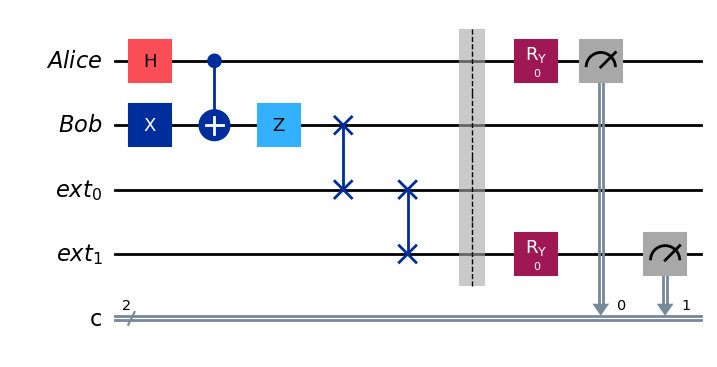

In [4]:
# Número máximo de SWAPs
n_swaps = 2


Ex = bell_with_swaps(n_swaps, theta_a=0.0, theta_b=0.0)
Ex.draw(output="mpl")  

# Criação do Backend

In [5]:
# --- Criar modelo de ruído ---
noise_model = NoiseModel()

# Erro de despolarização: probabilidade p de o estado virar mistura completamente mista
p1 = 0.01  # erro 1 qubit
p2 = 0.02  # erro 2 qubits

# Erro de relaxação térmica (T1 e T2 em microssegundos, tempo de porta em nanossegundos)
T1 = 50e3
T2 = 70e3
gate_time_1q = 50     # ns
gate_time_2q = 200    # ns

# Definir erros
error_1q = depolarizing_error(p1, 1).compose(
    thermal_relaxation_error(T1, T2, gate_time_1q)
)
error_2q = depolarizing_error(p2, 2).compose(
    thermal_relaxation_error(T1, T2, gate_time_2q).expand(
        thermal_relaxation_error(T1, T2, gate_time_2q)
    )
)

# Associar erros às portas
noise_model.add_all_qubit_quantum_error(error_1q, ["u1", "u2", "u3", "h", "x", "y", "z", "sdg"])
noise_model.add_all_qubit_quantum_error(error_2q, ["cx", "swap"])

# Erro de medida
meas_error = depolarizing_error(0.02, 1)
noise_model.add_all_qubit_quantum_error(meas_error, ["measure"])

# Backend com ruído
backend = AerSimulator(noise_model=noise_model)

## Ângulo para máxima violação

In [6]:
angles = {
    'A0B0': (0,           np.pi/4),
    'A0B1': (0,          -np.pi/4),
    'A1B0': (np.pi/2,     np.pi/4),
    'A1B1': (np.pi/2,    -np.pi/4),
}

## Correlação

In [7]:
# 3) Correlação E a partir das contagens
def correlacao(counts):
    """
    Converte counts ('00','01','10','11') em E = ⟨A·B⟩, mapeando 0->+1, 1->-1.
    Reverte a string para ficar [Alice, Bob] = [bit0, bit1].
    """
    shots = sum(counts.values())
    if shots == 0:
        return 0.0
    E = 0.0
    for outcome, freq in counts.items():
        bits = outcome[::-1]  # agora bits[0]=Alice, bits[1]=Bob
        a = 1 if bits[0] == '0' else -1
        b = 1 if bits[1] == '0' else -1
        E += a * b * (freq / shots)
    return E

## Calcular o Parâmetro S de Bell

In [8]:
def calcular_S(results_por_setting):
    """
    results_por_setting: dict com chaves 'A0B0','A0B1','A1B0','A1B1' -> counts
    """
    E00 = correlacao(results_por_setting['A0B0'])
    E01 = correlacao(results_por_setting['A0B1'])
    E10 = correlacao(results_por_setting['A1B0'])
    E11 = correlacao(results_por_setting['A1B1'])
    return E00 + E01 + E10 - E11

## Definição para calcular o valor de S (CHSH) em função do número de SWAPs

In [9]:
# Número máximo de SWAPs
num_swaps = 12

def chsh_vs_swaps(num_swaps, shots=2000):
    S_results = {}        # S_results[n] = S
    raw_counts = {}       # opcional: guardar contagens por setting

    for n in range(num_swaps + 1):
        results = {}
        for label, (ta, tb) in angles.items():
            qc = bell_with_swaps(n, theta_a=ta, theta_b=tb) 
            tqc = transpile(qc, backend,
                            basis_gates=['swap','h','x','y','z','h','cx','measure','sdg','ry'],
                            optimization_level=0)
            job = backend.run(tqc, shots=shots)
            counts = job.result().get_counts()
            results[label] = counts

        S_value = abs(calcular_S(results))  # Calcula apenas o módulo
        S_results[n] = S_value
        raw_counts[n] = results
        print(f"SWAPs = {n:>2d}  |  S = {S_value:.3f}")

    return S_results, raw_counts



## Função para obter os resultados 

In [10]:

# 1) Rodar a função para obter os resultados
S_results, raw_counts = chsh_vs_swaps(num_swaps=12, shots=1000000)

# 2) Preparar os dados para o gráfico
ns = list(S_results.keys())
S_vals = list(S_results.values())


c:\Users\Luan\anaconda3\envs\cwq\Lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


SWAPs =  0  |  S = 2.584
SWAPs =  1  |  S = 2.524
SWAPs =  2  |  S = 2.467
SWAPs =  3  |  S = 2.407
SWAPs =  4  |  S = 2.354
SWAPs =  5  |  S = 2.297
SWAPs =  6  |  S = 2.244
SWAPs =  7  |  S = 2.191
SWAPs =  8  |  S = 2.141
SWAPs =  9  |  S = 2.090
SWAPs = 10  |  S = 2.042
SWAPs = 11  |  S = 1.993
SWAPs = 12  |  S = 1.946


## Plotagem do gráficos 

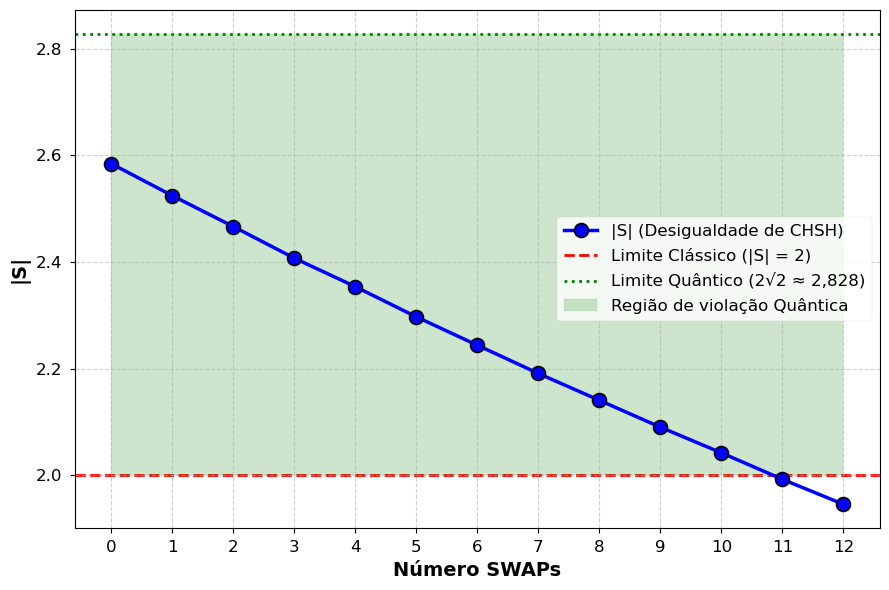

In [16]:
# Cálculo do valor absoluto de S
S_vals_abs = [abs(s) for s in S_vals]

plt.style.use("seaborn-v0_8-paper")
plt.figure(figsize=(9,6))

# Gráfico do valor absoluto de S
plt.plot(ns, S_vals_abs, marker='o', markersize=10, markeredgecolor='black', 
         markeredgewidth=1.2, linewidth=2.5, label='|S| (Desigualdade de CHSH)', 
         color='blue', zorder=2)

# Linhas de referência teóricas
plt.axhline(2, color='red', linestyle='--', linewidth=2, 
            label='Limite Clássico (|S| = 2)', zorder=1)
plt.axhline(2*np.sqrt(2), color='green', linestyle=':', linewidth=2, 
            label='Limite Quântico (2√2 ≈ 2,828)', zorder=1)

# Região de violação quântica (área sombreada)
plt.fill_between(ns, 2, 2*np.sqrt(2), alpha=0.2, color='green',
                 label='Região de violação Quântica', zorder=1)

# Rótulos e ajustes visuais
plt.xlabel("Número SWAPs", fontsize=14, fontweight="bold")
plt.ylabel("|S|", fontsize=14, fontweight="bold")
plt.xticks(ns, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12, frameon=True, loc='best')
plt.tight_layout()

plt.show()
